In [1]:
from pymavlink import mavutil
import math
import tkinter as tk
import socket
import time
import helper
import threading
import torch
import torch.nn as nn
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
SIM_COMPUTER_IP = '192.168.1.124'  # IP address of the simulation computer
PORT = 15000  # The same port as used by the server

In [3]:
def send_command(command):
    with socket.socket(socket.AF_INET, socket.SOCK_STREAM) as s:
        s.connect((SIM_COMPUTER_IP, PORT))
        s.sendall(command.encode('utf-8'))

def start_instance(instance_id, out_port):
    send_command(f"start {instance_id} {out_port}")

def stop_instance(instance_id):
    send_command(f"stop {instance_id}")

def connect(port):
    connection = mavutil.mavlink_connection(f'udpin:0.0.0.0:{port}') 

    connection.wait_heartbeat() #wait until we hear a heartbeat from the copter

    return connection 

def get_current_position(connection):

    msg = connection.recv_match(type='LOCAL_POSITION_NED', blocking=True)

    north = msg.x
    east = msg.y
    down = -msg.z

    return(north, east, down)

def wait_for_gps_lock(connection, timeout=60):
    start_time = time.time()
    while True:
        # Check for timeout
        if time.time() - start_time > timeout:
            print("Timeout waiting for GPS lock.")
            return False
            
        # Fetch GPS_RAW_INT messages
        msg = connection.recv_match(type='GPS_RAW_INT', blocking=True, timeout=5)
        if not msg:
            print("No GPS data received.")
            continue
            
        # Check for 3D lock
        if msg.fix_type >= 3:
            print(f"GPS lock acquired with {msg.satellites_visible} satellites.")
            return True
        else:
            print(f"Current GPS fix type: {msg.fix_type}, waiting for 3D lock...")

        time.sleep(1)


def arm(mavlink_connection):
    """
    Arms vehicle and fly to a target altitude.
    :param mavlink_connection: The connection to the vehicle
    :param target_altitude: Target altitude in meters
    """

    print("Basic pre-arm checks")
    # Wait for vehicle to initialize and become ready
    while not mavlink_connection.wait_heartbeat(timeout=5):
        print("Waiting for vehicle heartbeat")

           
    print("Setting vehicle to GUIDED mode")
    mavlink_connection.mav.set_mode_send(mavlink_connection.target_system, mavutil.mavlink.MAV_MODE_FLAG_CUSTOM_MODE_ENABLED, 4) 

    # Wait a bit for the mode to change
    time.sleep(2)

    # Copter should arm in GUIDED mode
    mavlink_connection.mav.command_long_send(
        mavlink_connection.target_system, mavlink_connection.target_component,
        mavutil.mavlink.MAV_CMD_COMPONENT_ARM_DISARM,
        0,  # Confirmation
        1,  # 1 to arm
        0, 0, 0, 0, 0, 0  # Unused parameters for this command
    )
def waitForEKF2(connection):
    while True:
        msg = connection.recv_match(type='STATUSTEXT', blocking=True, timeout=5)
        if msg is None:
            continue
        text = msg.text.decode('utf-8')
        if "EKF2 IMU0 is using GPS" in text:
            print("Received EKF2 GPS lock message.")
            return True

def takeoff(mavlink_connection, alt):
    #Assumes you have already set to guided mode and armed.

    mavlink_connection.mav.command_long_send(mavlink_connection.target_system, mavlink_connection.target_component, 
                                 mavutil.mavlink.MAV_CMD_NAV_TAKEOFF, 0, 0, 0, 0, 0, 0, 0, alt)
    
    #See how the copter responded to the takeoff command
    msg = mavlink_connection.recv_match(type = 'COMMAND_ACK', blocking = True)
    print(msg)

    while True:
        # Wait for the next LOCAL_POSITION_NED message
        msg = mavlink_connection.recv_match(type='LOCAL_POSITION_NED', blocking=True)
        
    
        # Check if altitude is within a threshold of the target altitude
        if abs(msg.z * -1 - alt) < 1.0:
            print("Reached target altitude")
            break

#send local frame coordinates and have copter fly over that spot.
def send_waypoint_local(connection, x, y, alt):
    connection.mav.send(mavutil.mavlink.MAVLink_set_position_target_local_ned_message
                    (10, connection.target_system, connection.target_component, mavutil.mavlink.MAV_FRAME_LOCAL_NED, 
                     int(0b010111111000), x, y, alt,
                      0, 0, 0, 0, 0, 0, 0, 0))

    time.sleep(1)


In [4]:
def plot_3d_paths(results):
    # Create a new figure for plotting
    fig = plt.figure(figsize=(10, 8))
    
    # Determine the number of subplots based on the number of paths
    num_paths = len(results)
    cols = 2  # You can adjust the number of columns based on your preference
    rows = (num_paths + cols - 1) // cols  # Calculate rows needed
    
    # Plot each path in a subplot
    for index, (pid, path) in enumerate(results.items(), start=1):
        ax = fig.add_subplot(rows, cols, index, projection='3d')
        # Assuming path is a list of [north, east, down] coordinates
        path = np.array(path)  # Convert path to a NumPy array for easier slicing
        ax.plot(path[:, 0], path[:, 1], path[:, 2], marker='o')  # Plot the 3D path
        ax.plot(5, 5, 5, marker = 'o', color='red')
        
        ax.set_xlabel('North')
        ax.set_ylabel('East')
        ax.set_zlabel('Down')
        ax.set_title(f'PID {pid} Flight Path')

    plt.tight_layout()
    plt.show()

In [5]:
# GANN definitions #

class DroneNet(nn.Module):
    def __init__(self):
        super(DroneNet, self).__init__()
        self.fc1 = nn.Linear(3, 10)  # First hidden layer from 3 inputs to 10 nodes
        self.fc2 = nn.Linear(10, 5)  # Second hidden layer from 10 nodes to 5 nodes
        self.output = nn.Linear(5, 3)  # Output layer from 5 nodes to 3 outputs (NED coordinates)

    def forward(self, x):
        x = torch.relu(self.fc1(x))  # Activation function for first hidden layer
        x = torch.relu(self.fc2(x))  # Activation function for second hidden layer
        x = self.output(x)  # Output layer, no activation (linear output)
        return x
    
def get_fitness(path, target):
    # calculate how close final position was to target and the total distance.
    # return a fitness that rewards closeness to target and minumum distance flown.
    final_position = path[-1]
    fp_north, fp_east, fp_down = final_position
    t_north, t_east, t_down = target

    distance_from_target = np.sqrt((fp_north-t_north)**2 + (fp_east-t_east)**2 + (fp_down-t_down)**2)

    total_distance = 0
    for i in range(1, len(path)):
        n, e, d = path[i]
        old_n, old_e, old_d = path[i-1]

        total_distance += np.sqrt((old_n-n)**2 + (old_e-e)**2 + (old_d-d)**2)
    
    fitness = 1 / (distance_from_target + 1) + 1 / (total_distance + 1)
    return fitness

starting instance 0 on port 14560
starting instance 1 on port 14561
starting instance 2 on port 14562
instance 2 - Heartbeat Recieved!
instance 1 - Heartbeat Recieved!
instance 0 - Heartbeat Recieved!
instance 2 - arming throttle in GUIDED mode.
Basic pre-arm checks
Setting vehicle to GUIDED mode
instance 1 - arming throttle in GUIDED mode.
Basic pre-arm checks
Setting vehicle to GUIDED mode
instance 0 - arming throttle in GUIDED mode.
Basic pre-arm checks
Setting vehicle to GUIDED mode
instance 2 - sending takeoff command
instance 1 - sending takeoff command
COMMAND_ACK {command : 410, result : 4, progress : 0, result_param2 : 0, target_system : 0, target_component : 0}
instance 0 - sending takeoff command
COMMAND_ACK {command : 410, result : 4, progress : 0, result_param2 : 0, target_system : 0, target_component : 0}
COMMAND_ACK {command : 410, result : 4, progress : 0, result_param2 : 0, target_system : 0, target_component : 0}
Reached target altitude
Reached target altitude
Reached

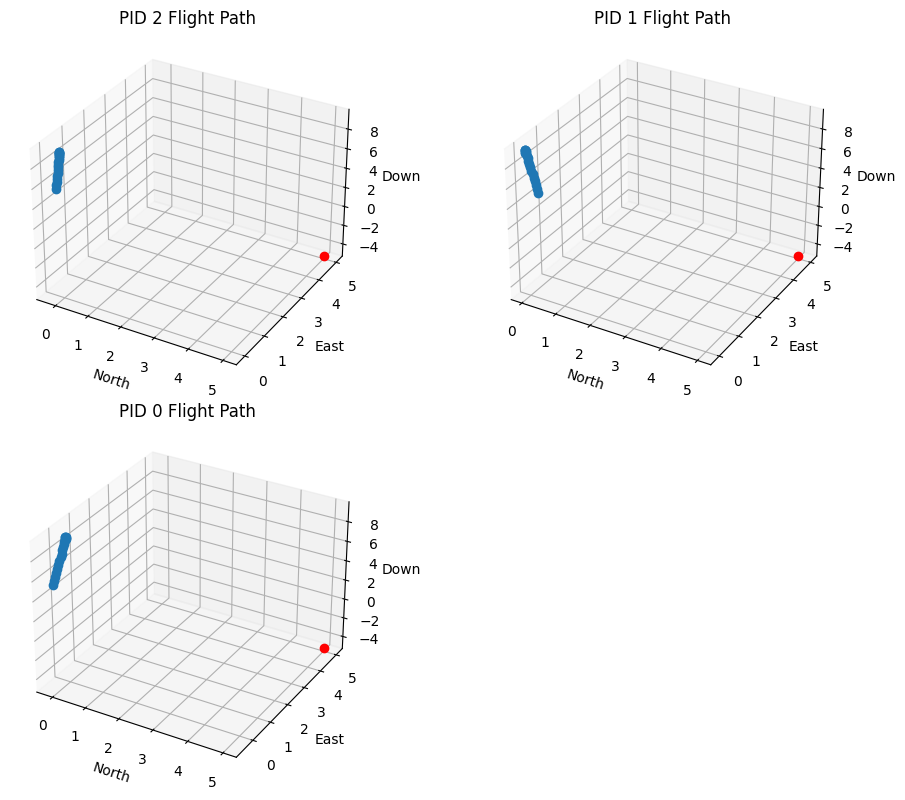

In [6]:
out_port_base = 14560
pid_base = 0
instance_count = 3  # Number of episodes you want to run in each epoch

def simulate_drone(pid, out_port, network, result_dict, results_lock):
    print(f"starting instance {pid} on port {out_port}")
    start_instance(pid, out_port)
    drone_connection = connect(out_port)

    # Print heartbeat information
    while True:
        msg = drone_connection.recv_match(type='HEARTBEAT', blocking=True)
        if not msg:
            print(f"instance {pid} - No heartbeat")
        else:
            print(f"instance {pid} - Heartbeat Recieved!")
            break  # or remove to keep listening

    time.sleep(40)

    print(f"instance {pid} - arming throttle in GUIDED mode.")
    arm(drone_connection)

    print(f"instance {pid} - sending takeoff command")
    takeoff(drone_connection, 10)

    path = []

    for i in range(20):
        north, east, down = get_current_position(drone_connection)
        #print(f'Instance {pid} - North: {north}, East: {east}, Down: {down}')


        current_pos = [north, east, down]
        path.append(current_pos)

        with torch.no_grad():
            input_tensor = torch.tensor(current_pos, dtype=torch.float32).unsqueeze(0)
            next_position = network(input_tensor).numpy()[0]  # Remove batch dimension and convert to numpy

        new_north, new_east, new_down = next_position

        print(f"Instance {pid} sending neurotic waypoint: {new_north}, {new_east}, {new_down}")

        send_waypoint_local(drone_connection, new_north, new_east, new_down)
        

    helper.plot_trajectory()
    helper.reset_trajectory()
    time.sleep(1)

    print(f"stopping instance {pid}")
    stop_instance(pid)

    result_dict[pid] = path

def main():
    threads = []
    results = {} # dict to store results of each instance
    results_lock = threading.Lock()  # Lock for managing access to results
    epochs = 3

    for j in range(epochs):

        print(f"<----------------------- EPOCH #{j} ------------------------->")

        for i in range(instance_count):
            pid = pid_base + i
            out_port = out_port_base + i

            network = DroneNet()
            t = threading.Thread(target=simulate_drone, args=(pid, out_port, network, results, results_lock))

            t.start()
            threads.append(t)


        for t in threads:
            t.join()

        with results_lock:
            for pid, path in results.items():
                print(f'PID {pid} path: {path}')
            plot_3d_paths(results)

if __name__ == "__main__":
    main()

    